Original Data

Epoch 1/10 - Loss: 15.7712 - Train Accuracy: 0.6164
Epoch 2/10 - Loss: 3.5279 - Train Accuracy: 0.8989
Epoch 3/10 - Loss: 1.3721 - Train Accuracy: 0.9351
Epoch 4/10 - Loss: 0.8848 - Train Accuracy: 0.9752
Epoch 5/10 - Loss: 0.5414 - Train Accuracy: 0.9828
Epoch 6/10 - Loss: 0.4570 - Train Accuracy: 0.9790
Epoch 7/10 - Loss: 0.3495 - Train Accuracy: 0.9847
Epoch 8/10 - Loss: 0.2935 - Train Accuracy: 0.9885
Epoch 9/10 - Loss: 0.4746 - Train Accuracy: 0.9790
Epoch 10/10 - Loss: 0.1581 - Train Accuracy: 0.9962
✅ Model saved to fruit_classifier.pth

📊 Classification Report:

              precision    recall  f1-score   support

 freshapples       0.96      0.96      0.96        48
 freshbanana       0.96      0.98      0.97        49
freshoranges       0.97      0.94      0.96        35

    accuracy                           0.96       132
   macro avg       0.96      0.96      0.96       132
weighted avg       0.96      0.96      0.96       132



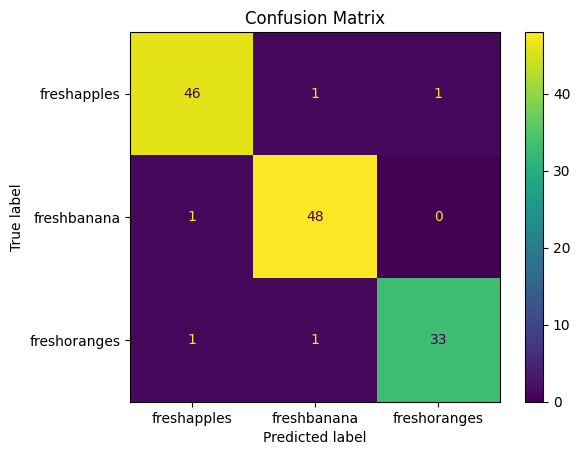

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Device Configuration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data Transforms

image_dim = 64

train_transform = transforms.Compose([
    transforms.Resize((image_dim, image_dim)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.Resize((image_dim, image_dim)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Dataset & Loaders

dataset_path = "images/"
full_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=train_transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform  # change val transform

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# CNN Architecture (Improved)

class FruitClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FruitClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Training Function

def train_model(model, train_loader, val_loader, device, epochs=10, save_path=None):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        scheduler.step()
        accuracy = correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Train Accuracy: {accuracy:.4f}")

    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"✅ Model saved to {save_path}")

# Evaluation Function

def evaluate_model(model, val_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\n📊 Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()


# Run Training & Evaluation

num_classes = len(full_dataset.classes)
model = FruitClassifier(num_classes)

train_model(model, train_loader, val_loader, device, epochs=10, save_path="fruit_classifier.pth")
evaluate_model(model, val_loader, device, full_dataset.classes)


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --------- Class Names ---------

class_names = ['freshapples', 'freshbanana', 'freshoranges']
num_classes = len(class_names)

# --------- Load Trained Model ---------
model = FruitClassifier(num_classes)
model.load_state_dict(torch.load("fruit_classifier.pth", map_location=device))
model.to(device)
model.eval()

# --------- Define Transform ---------
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# --------- Classify Images in Folder ---------
generated_folder = "final_generated_images"

print("Classifying generated images...\n")

all_preds = []
all_labels = []  


for filename in sorted(os.listdir(generated_folder)):
    if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg"):
        img_path = os.path.join(generated_folder, filename)
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)
            predicted_class = class_names[predicted.item()]
        
        print(f"{filename} --> {predicted_class}")
        
        all_preds.append(predicted.item())

  
        for idx, class_name in enumerate(class_names):
            if class_name in filename.lower():
                all_labels.append(idx)
                break



Classifying generated images...

final_image_0.png --> freshoranges
final_image_1.png --> freshbanana
final_image_10.png --> freshoranges
final_image_11.png --> freshapples
final_image_12.png --> freshbanana
final_image_13.png --> freshoranges
final_image_14.png --> freshapples
final_image_15.png --> freshoranges
final_image_2.png --> freshoranges
final_image_3.png --> freshapples
final_image_4.png --> freshapples
final_image_5.png --> freshbanana
final_image_6.png --> freshapples
final_image_7.png --> freshoranges
final_image_8.png --> freshoranges
final_image_9.png --> freshbanana


C:\Users\tmana\AppData\Local\Temp\ipykernel_92336\3692217580.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fruit_classifier.pth", ma

Synthetic Data

Epoch 1/10 - Loss: 13.1258 - Train Accuracy: 0.6069
Epoch 2/10 - Loss: 3.8631 - Train Accuracy: 0.8893
Epoch 3/10 - Loss: 1.7399 - Train Accuracy: 0.9351
Epoch 4/10 - Loss: 1.0786 - Train Accuracy: 0.9676
Epoch 5/10 - Loss: 0.7116 - Train Accuracy: 0.9656
Epoch 6/10 - Loss: 0.7641 - Train Accuracy: 0.9771
Epoch 7/10 - Loss: 0.5022 - Train Accuracy: 0.9790
Epoch 8/10 - Loss: 0.2997 - Train Accuracy: 0.9943
Epoch 9/10 - Loss: 0.5210 - Train Accuracy: 0.9924
Epoch 10/10 - Loss: 0.5477 - Train Accuracy: 0.9656
✅ Model saved to test_fruit_classifier.pth
Total predictions: 132, Total labels: 132
Unique predicted classes: {0, 1, 2}
Unique true labels: {0, 1, 2}

📊 Classification Report:

              precision    recall  f1-score   support

 freshapples       1.00      0.73      0.84        55
 freshbanana       0.98      1.00      0.99        41
freshoranges       0.72      1.00      0.84        36

    accuracy                           0.89       132
   macro avg       0.90      0.91     

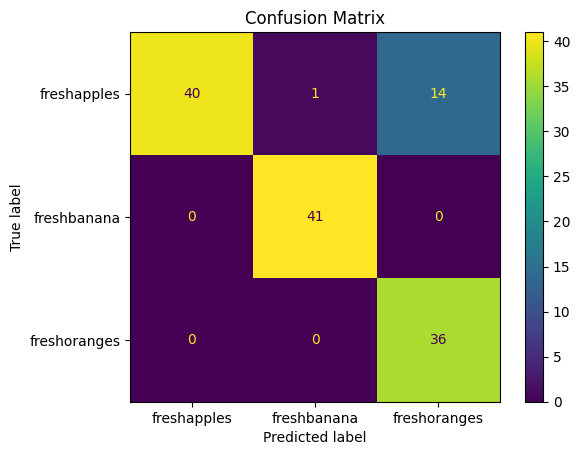

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Device Configuration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data Transforms

image_dim = 64

train_transform = transforms.Compose([
    transforms.Resize((image_dim, image_dim)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.Resize((image_dim, image_dim)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Dataset & Loaders

dataset_path = "images/"
full_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=train_transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform  # change val transform

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# CNN Architecture (Improved)

class FruitClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FruitClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Training Function

def train_model(model, train_loader, val_loader, device, epochs=10, save_path=None):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        scheduler.step()
        accuracy = correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Train Accuracy: {accuracy:.4f}")

    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"✅ Model saved to {save_path}")

# Evaluation Function

def evaluate_model(model, val_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Total predictions: {len(all_preds)}, Total labels: {len(all_labels)}")


    # Get the unique predicted classes
    unique_preds = set(all_preds)
    unique_labels = set(all_labels)

    print(f"Unique predicted classes: {unique_preds}")
    print(f"Unique true labels: {unique_labels}")

    # Check if the number of classes in predictions matches the target_names
    missing_classes = set(range(len(class_names))) - unique_preds
    if missing_classes:
        print(f"Missing predicted classes: {[class_names[i] for i in missing_classes]}")

    # Print the classification report and confusion matrix
    print("\n📊 Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()



# Run Training & Evaluation

num_classes = len(full_dataset.classes)
model = FruitClassifier(num_classes)

train_model(model, train_loader, val_loader, device, epochs=10, save_path="test_fruit_classifier.pth")
evaluate_model(model, val_loader, device, full_dataset.classes)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler


# --------- Class Names ---------
# Make sure these match the folder names used in training
class_names = ['freshapples', 'freshbanana', 'freshoranges']
num_classes = len(class_names)

# --------- Load Trained Model ---------
model = FruitClassifier(num_classes)
model.load_state_dict(torch.load("fruit_classifier.pth", map_location=device))
model.to(device)
model.eval()

# --------- Define Transform ---------
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



C:\Users\tmana\AppData\Local\Temp\ipykernel_96052\327970295.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fruit_classifier.pth", map

Training on Synthesized Data...

Epoch 1/10 - Loss: 1.2012 - Train Accuracy: 0.2500
Epoch 2/10 - Loss: 1.3342 - Train Accuracy: 0.7500
Epoch 3/10 - Loss: 0.4157 - Train Accuracy: 0.9167
Epoch 4/10 - Loss: 0.5047 - Train Accuracy: 0.8333
Epoch 5/10 - Loss: 0.1086 - Train Accuracy: 0.9167
Epoch 6/10 - Loss: 0.0061 - Train Accuracy: 1.0000
Epoch 7/10 - Loss: 0.0055 - Train Accuracy: 1.0000
Epoch 8/10 - Loss: 0.0243 - Train Accuracy: 1.0000
Epoch 9/10 - Loss: 0.0202 - Train Accuracy: 1.0000
Epoch 10/10 - Loss: 0.0383 - Train Accuracy: 1.0000

Evaluating on Synthesized Data (FULL SET)...

Total predictions: 16, Total labels: 16
Unique predicted classes: {0, 1, 2}
Unique true labels: {0, 1, 2}

📊 Classification Report:

              precision    recall  f1-score   support

 freshapples       0.45      1.00      0.62         5
 freshbanana       1.00      0.67      0.80         3
freshoranges       1.00      0.38      0.55         8

    accuracy                           0.62        16
   m

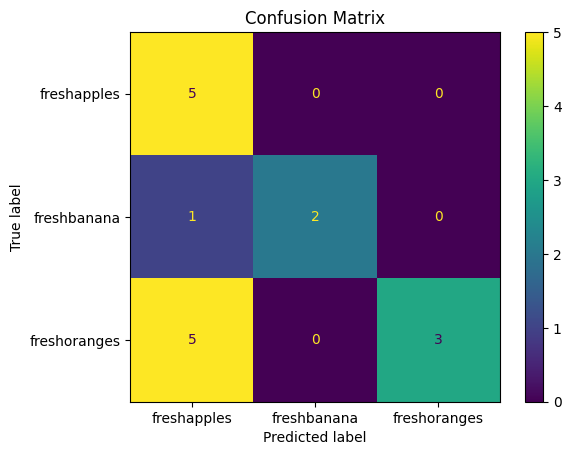

Model saved as 'fruit_classifier_synthesized.pth'


In [25]:
# Path to synthesized dataset
synth_path = 'final_generated_images/Synthesised_data/'

# Load synthesized dataset
synth_dataset = torchvision.datasets.ImageFolder(root=synth_path, transform=transform)

# Split into train and validation
train_size = int(0.8 * len(synth_dataset))
val_size = len(synth_dataset) - train_size
synth_train_dataset, synth_val_dataset = random_split(synth_dataset, [train_size, val_size])

synth_train_loader = DataLoader(synth_train_dataset, batch_size=64, shuffle=True)
synth_val_loader = DataLoader(synth_val_dataset, batch_size=64, shuffle=False)

# Create a new model instance (or reuse if desired)
model_synth = FruitClassifier(num_classes=len(synth_dataset.classes))

# Train
print("Training on Synthesized Data...\n")
train_model(model_synth, synth_train_loader, synth_val_loader, device, epochs=10)

# Evaluate on the full synthesized dataset (instead of validation split)
print("\nEvaluating on Synthesized Data (FULL SET)...\n")
synth_full_loader = DataLoader(synth_dataset, batch_size=64, shuffle=False)
evaluate_model(model_synth, synth_full_loader, device, synth_dataset.classes)

# Save model
torch.save(model_synth.state_dict(), "fruit_classifier_synthesized.pth")
print("Model saved as 'fruit_classifier_synthesized.pth'")



Training with 10% of training data (52 samples)
Epoch [1/5], Loss: 1.1000, Accuracy: 0.2692
Epoch [2/5], Loss: 1.1581, Accuracy: 0.4615
Epoch [3/5], Loss: 1.0412, Accuracy: 0.4615
Epoch [4/5], Loss: 1.0424, Accuracy: 0.5769
Epoch [5/5], Loss: 1.0143, Accuracy: 0.5192

Training with 30% of training data (157 samples)
Epoch [1/5], Loss: 3.3513, Accuracy: 0.2994
Epoch [2/5], Loss: 3.1139, Accuracy: 0.5860
Epoch [3/5], Loss: 2.5699, Accuracy: 0.6561
Epoch [4/5], Loss: 1.7328, Accuracy: 0.7898
Epoch [5/5], Loss: 1.1124, Accuracy: 0.8344

Training with 50% of training data (262 samples)
Epoch [1/5], Loss: 5.5405, Accuracy: 0.3931
Epoch [2/5], Loss: 4.1927, Accuracy: 0.6832
Epoch [3/5], Loss: 3.9195, Accuracy: 0.6145
Epoch [4/5], Loss: 2.7974, Accuracy: 0.7176
Epoch [5/5], Loss: 2.1490, Accuracy: 0.8550

Training with 70% of training data (366 samples)
Epoch [1/5], Loss: 6.3181, Accuracy: 0.4727
Epoch [2/5], Loss: 4.2123, Accuracy: 0.7404
Epoch [3/5], Loss: 2.6578, Accuracy: 0.8388
Epoch [4/

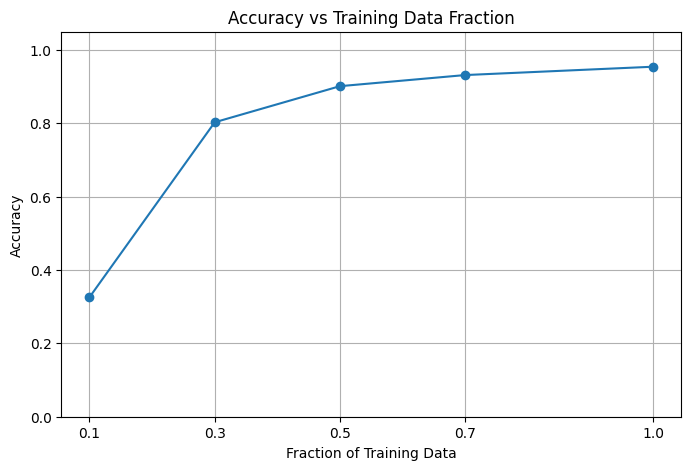

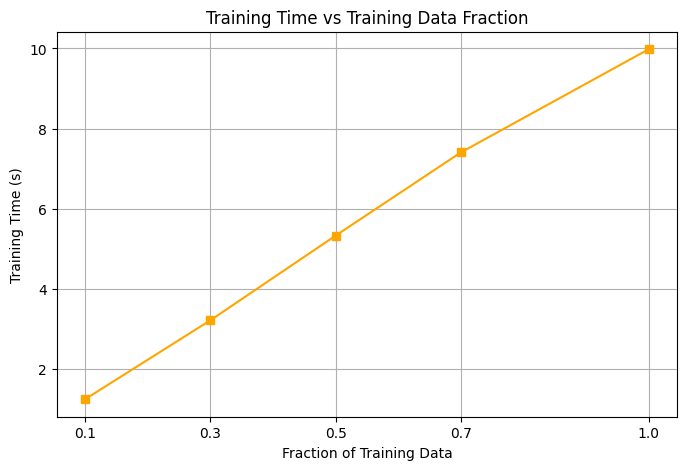

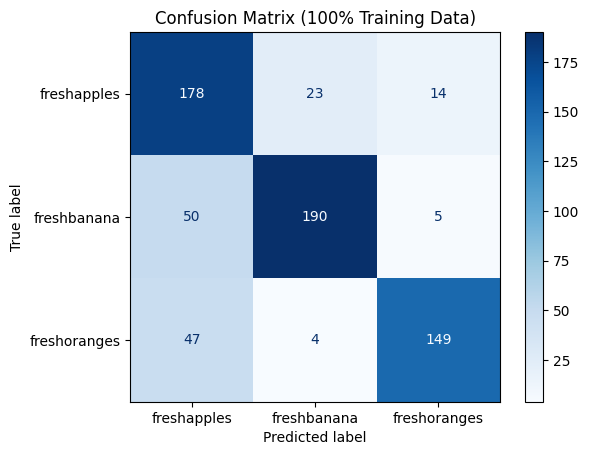

In [6]:
import time
import matplotlib.pyplot as plt  # Optional: for plotting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ---- Run Analysis on Varying Dataset Sizes ---- #

fractions = [0.1, 0.3, 0.5, 0.7, 1.0]
results = []

all_preds = []
all_labels = []

for frac in fractions:
    subset_size = int(frac * len(train_dataset))
    subset, _ = random_split(train_dataset, [subset_size, len(train_dataset) - subset_size])
    train_loader_subset = DataLoader(subset, batch_size=64, shuffle=True)

    model = SimpleCNN(num_classes).to(device)

    print(f"\nTraining with {int(frac*100)}% of training data ({subset_size} samples)")
    start = time.time()
    train_classifier(model, train_loader_subset, val_loader, device, epochs=5)
    end = time.time()

    # Evaluate accuracy
    model.eval()
    correct = 0
    total = 0
    if frac == 1.0:
        last_preds = all_preds
        last_labels = all_labels


    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())



    acc = correct / total

    results.append((frac, acc, end - start))



# ---- Print and Plot Results ---- #
print("\n--- Analysis Results ---")
for frac, acc, t in results:
    print(f"Data fraction: {frac:.1f} | Accuracy: {acc:.4f} | Time: {t:.2f}s")

# Optional Plot
fractions_list = [r[0] for r in results]
accuracies = [r[1] for r in results]
times = [r[2] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(fractions_list, accuracies, marker='o')
plt.title("Accuracy vs Training Data Fraction")
plt.xlabel("Fraction of Training Data")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(fractions_list)
plt.ylim(0, 1.05)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(fractions_list, times, marker='s', color='orange')
plt.title("Training Time vs Training Data Fraction")
plt.xlabel("Fraction of Training Data")
plt.ylabel("Training Time (s)")
plt.grid(True)
plt.xticks(fractions_list)
plt.show()

#confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix ({int(frac*100)}% Training Data)")
plt.show()
